<a href="https://colab.research.google.com/github/bdgToji/VNP/blob/main/KOL2_NN_Heart_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Даден е dataset кој содрзжи податоци за пациенти. Целта е да се предвидат вредностите од колоната target, која означува дали пациентот ќе има или нема да има срцев удар - инфаркт (1/0) според дадените карактеристики на пациентите.
Невронската мрежа треба да ги содржи следниве слоеви:

Конволуциски слој составен од 50 неврона, со големина на прозорец 10 и ист padding. Конволуциски слој со 16 неврона, со големина на прозорец 1 и валиден padding. MaxPooling слој со pool size 8 и ист padding. Сите скриени слоеви имаат sigmoid активациска фуннкција, функцијата на загуба (loss function), оптимизатор, метрики за точност, како и останати параметри ако има потреба, потребно е да ги дефинирате вие.

Дополнително потребно е да се внесе некој механизам за спречување на overfitting.

Бројот на епохи на кои треба да ја тренирате невронската мрежа е 4 со големина на batch од 12.

# Симнете го податочното множество

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv1D, Dropout, Input, MaxPooling1D, Flatten, MaxPooling1D
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/VNP/heart.csv')

In [4]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Направете претпроцесирање на податоците

In [5]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# Поделето го на тренирачко и тестирачко множество во сооднос 80:20

In [7]:
X, Y = df.drop(columns=['target']), df['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [8]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [10]:
X_train.shape, X_test.shape

((242, 13), (61, 13))

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
X_train.shape, X_test.shape

((242, 13, 1), (61, 13, 1))

# Искористете соодветна невронска мрежа

In [35]:
model = Sequential()
model.add(Conv1D(50, 10, padding='same', activation='sigmoid', input_shape=(13, 1)))
model.add(Conv1D(16, 1, padding='valid', activation='sigmoid'))
model.add(MaxPooling1D(pool_size=8, padding='same'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

In [36]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [37]:
history = model.fit(X_train, Y_train, epochs=4, batch_size=12, validation_split=0.2)

Epoch 1/4
17/17 [==============================] - 5s 63ms/step - loss: 0.7477 - accuracy: 0.5285 - val_loss: 0.7269 - val_accuracy: 0.5510
Epoch 2/4
17/17 [==============================] - 0s 5ms/step - loss: 0.7265 - accuracy: 0.5285 - val_loss: 0.7056 - val_accuracy: 0.5510
Epoch 3/4
17/17 [==============================] - 0s 5ms/step - loss: 0.7084 - accuracy: 0.5233 - val_loss: 0.6950 - val_accuracy: 0.5510
Epoch 4/4
17/17 [==============================] - 0s 6ms/step - loss: 0.7020 - accuracy: 0.5181 - val_loss: 0.6909 - val_accuracy: 0.5510


# Тестирајте го моделот на тестирачкото множество со метриките за евалуација на дадениот проблем

In [38]:
model.evaluate(X_test, Y_test)

2/2 [==============================] - 0s 8ms/step - loss: 0.6849 - accuracy: 0.5902


[0.6848510503768921, 0.5901639461517334]

In [39]:
preds = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


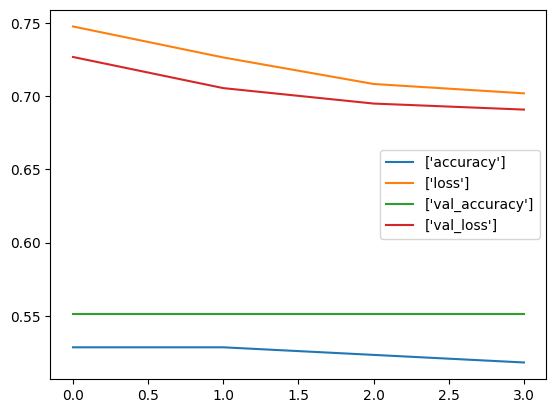

In [40]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label=['accuracy'])
plt.plot(history.history['loss'], label=['loss'])
plt.plot(history.history['val_accuracy'], label=['val_accuracy'])
plt.plot(history.history['val_loss'], label=['val_loss'])
plt.legend()
plt.show()

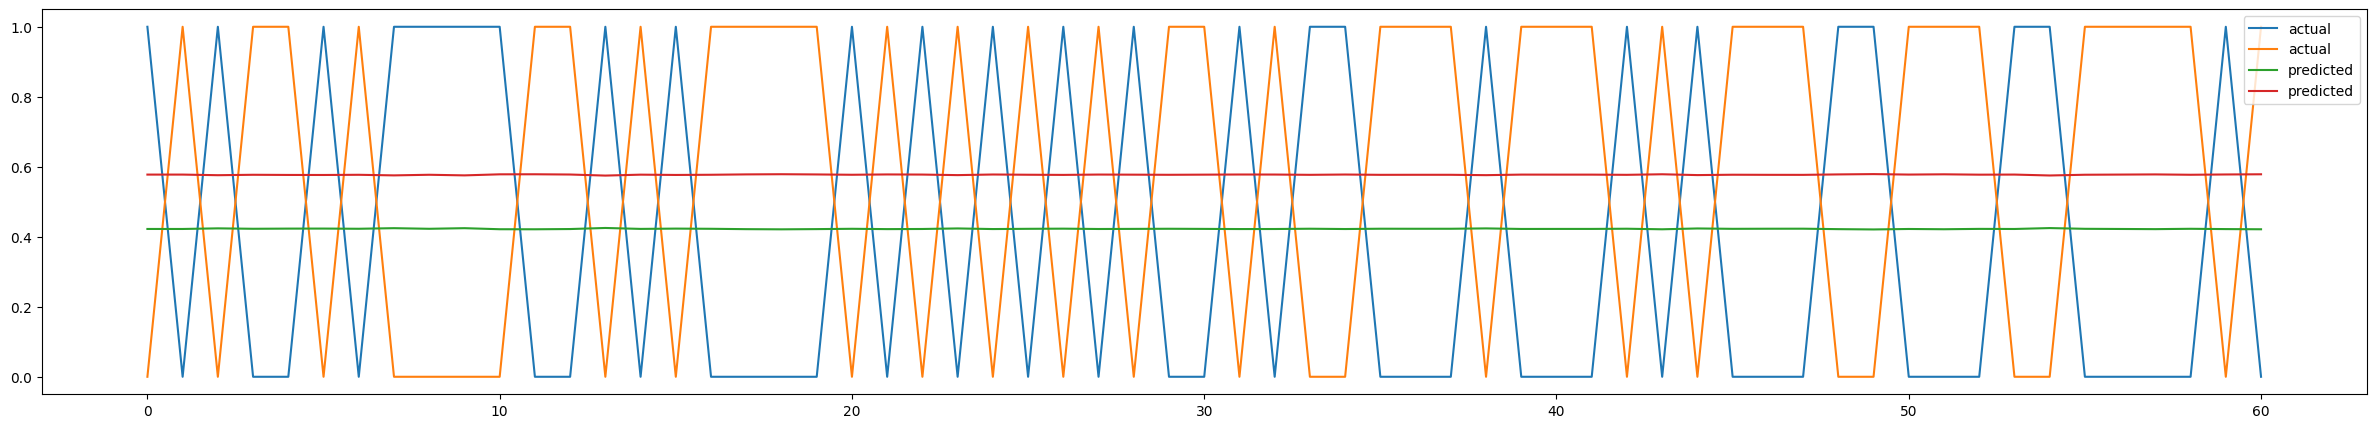

In [41]:
plt.figure(figsize=(30, 5))
plt.plot(Y_test, label='actual')
plt.plot(preds, label='predicted')
plt.legend()
plt.show()